#START

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, wasserstein_distance, probplot
from scipy.special import lambertw
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import time
import random
import tensorflow as tf
import tensorflow_probability as tfp

import pandas as pd

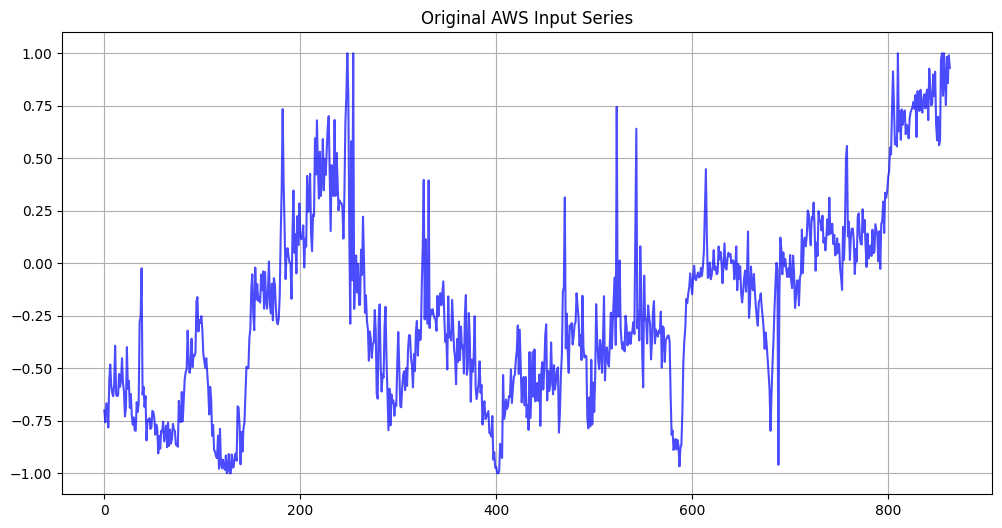

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Load the normalized syn_norm data
syn_norm_data = pd.read_csv("syn_norm_subset_2000_bins.csv", index_col='time_bin')

# Extract the 'syn_norm' column as a numpy array
syn_norm_series = syn_norm_data['syn_norm'].values.astype(float)

# Convert to TensorFlow tensor (similar to your previous step)
scaled_syn_norm = tf.convert_to_tensor(syn_norm_series)
scaled = scaled_syn_norm

print("Scaled syn_norm series range:", tf.reduce_min(scaled_syn_norm), tf.reduce_max(scaled_syn_norm))

In [ ]:
class WGAN_GP(tf.keras.Model):
    def __init__(self, num_epochs, batch_size, latent_dim, window_size, n_critic, gp):
        super(WGAN_GP, self).__init__()
        # define the critic and generator networks
        self.critic = self.define_critic_model(window_size)
        self.generator = self.define_generator_model(latent_dim, window_size)
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.window_size = window_size
        self.n_critic = n_critic
        self.gp = gp
        # average critic and generator losses for each epoch
        self.critic_loss_avg = []
        self.generator_loss_avg = []
        # Earth's mover distance (EMD) for each epoch
        self.emd_avg = []
        # stylized facts RMSEs for each epoch
        self.acf_avg = []
        self.vol_avg = []
        self.lev_avg = []

    def define_critic_model(self, window_length):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, input_shape=(window_length, 1), padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Flatten())

        model.add(tf.keras.layers.Dense(32, dtype=tf.float64))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))

        model.add(tf.keras.layers.Dense(1, dtype=tf.float64))

        return model

    def define_generator_model(self, latent_dim, window_length):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(30, input_shape=(latent_dim,)))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Dense(50))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Dense(50))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))

        model.add(tf.keras.layers.Dense(50))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))

        model.add(tf.keras.layers.Dense(window_length, dtype=tf.float64))

        return model

    # compile model with given optimizers for critic and generator networks
    def compile_WGAN(self, c_optimizer, g_optimizer):
        super(WGAN_GP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer

    def train_wgan_gp(self, gan_data, original_data, preprocessed_data, num_elements):
        """
        Parameters:
         - gan_data is the preprocessed dataset with windows for WGAN training
         - original_data is the original iio log-returns for evaluation of RMSEs (monitoring purposes)
         - preprocessed_data is the preprocessed log-returns without the last normalization step and without windows
          (for reversing the process of generated samples using the mean and std and evaluating the RMSEs)
        """
        for epoch in range(self.num_epochs):
            print(f'Processing epoch {epoch+1}/{self.num_epochs}')
            ################################################################
            #
            # Train the critic for n_critic iterations
            # Process 'batch_size' samples in each iteration independently
            #
            ################################################################
            # critic loss for 'n_critic' iterations
            critic_t_sum = 0
            for t in range(self.n_critic):
                # record the gradients
                with tf.GradientTape() as critic_tape:
                    # critic loss for 'batch_size' samples
                    critic_sum = 0
                    for i in range(self.batch_size):
                        # shuffle the dataset
                        shuffled_data = gan_data.shuffle(buffer_size=num_elements)
                        # take a single random element from the shuffled dataset
                        random_element = shuffled_data.take(1)
                        # iterate over the random_element dataset to access the value
                        for element in random_element:
                            # access the value of the random element as a tensor
                            real_sample = element
                        # reshape the real sample for compatibility with the first layer of the critic
                        real_sample = tf.reshape(real_sample, (1, self.window_size))

                        # generate latent noise for the generator
                        latent_noise = tf.random.normal(shape=(1, self.latent_dim))

                        # generate fake samples using the generator
                        generated_sample = self.generator(latent_noise)

                        # calculate the critic scores for real and fake samples
                        real_score = self.critic(real_sample)
                        fake_score = self.critic(generated_sample)

                        # compute the gradient penalty
                        gradient_penalty = self.compute_gradient_penalty(real_sample, generated_sample)

                        # calculate the Wasserstein distance loss with gradient penalty
                        critic_loss = fake_score - real_score + self.gp * gradient_penalty
                        # accumulate the critic loss for the sample
                        critic_sum += critic_loss

                    # compute the gradients of critic and apply them
                    critic_gradients = critic_tape.gradient(critic_sum/self.batch_size, self.critic.trainable_variables)
                    self.c_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))

                # accumulate the average critic loss for all samples in this 't' iteration
                critic_t_sum += critic_sum/self.batch_size

            # average critic loss for this epoch of WGAN training
            self.critic_loss_avg.append(critic_t_sum/self.n_critic)

            ################################################################
            #
            # Train generator for one iteration
            #
            ################################################################
            # sample a batch of latent variables
            latent_noise = tf.random.normal(shape=(self.batch_size, self.latent_dim))
            with tf.GradientTape() as gen_tape:
                # generate fake samples using the generator
                generated_samples = self.generator(latent_noise)
                # calculate the critic scores for fake samples
                fake_scores = self.critic(generated_samples)
                # calculate the generator loss
                generator_loss = -tf.reduce_mean(fake_scores)

            # compute the gradients of generator and apply them
            generator_gradients = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))

            # average generator loss for this epoch
            self.generator_loss_avg.append(generator_loss)

            #######################################################################################################
            #
            # Calculate the stylized facts RMSEs and the EMD for real and fake data
            #
            # Fake data has shape (num_samples x window_size), where num_samples = original_length / window_size
            # in order to get a time series close to the length of the original
            #
            #######################################################################################################
            # generate noise
            num_samples = len(original_data) // self.window_size
            latent_noise = tf.random.normal(shape=(num_samples, self.latent_dim))
            # generate fake samples using the generator
            batch_generated = self.generator.predict(latent_noise, verbose=0)
            # concatenate all time series data into one
            generated_data = tf.reshape(batch_generated, shape=(num_samples*self.window_size,))

            # reverse the preprocessing on generated sample
            #transformed_iio_denorm = denormalize(generated_data, tf.reduce_mean(preprocessed_data), tf.math.reduce_std(preprocessed_data))
            original_norm = generated_data
            fake_original = generated_data

            # calculate the temporal metrics for monitoring the training process
            emd = self.distribution_distance(original_data, fake_original)
            # store the EMD and RMSEs of stylized facts
            self.emd_avg.append(emd)

            # checkpoint saving
            if (epoch + 1) % 20 == 0:
                self.generator.save_weights(f"checkpoints/generator_epoch_WGAN_{epoch+1}.weights.h5")
                self.critic.save_weights(f"checkpoints/critic_epoch_WGAN_{epoch+1}.weights.h5")

            # print progress every 100 epochs
            if epoch % 2 == 0 or epoch+1 == 3000:
                print(f'\nEpoch {epoch+1} completed')
                #print(f'Critic loss (average): {self.critic_loss_avg[epoch][-1][0]}')
                print(f'Critic loss (average): {self.critic_loss_avg[epoch].numpy()}')
                print(f'Generator loss (average): {self.generator_loss_avg[epoch]}')
                print(f'\nEMD (average): {self.emd_avg[epoch]}')
                print()

    ###########################################################
    #
    # Sample a random number epsilon ~ U[0,1]
    # Create a convex combination of real and generated sample
    # Compute the gradient penalty for the critic network
    #
    ###########################################################
    def compute_gradient_penalty(self, real_sample, generated_sample):
        epsilon = tf.random.uniform((), dtype=tf.float64)
        interpolated_sample = epsilon * real_sample + (1 - epsilon) * generated_sample

        with tf.GradientTape() as tape:
            tape.watch(interpolated_sample)
            scores = self.critic(interpolated_sample)

        gradients = tape.gradient(scores, interpolated_sample)
        gradients_norm = tf.norm(gradients)
        gradient_penalty = (gradients_norm - 1)**2

        return gradient_penalty

    def distribution_distance(self, real, fake):
        bin_edges = np.linspace(-1, 1, num=50)
        empirical_real, _ = np.histogram(real, bins=bin_edges, density=True)
        empirical_fake, _ = np.histogram(fake, bins=bin_edges, density=True)
        # normalize safely
        if empirical_real.sum() > 0: empirical_real /= empirical_real.sum()
        if empirical_fake.sum() > 0: empirical_fake /= empirical_fake.sum()
        return wasserstein_distance(empirical_real, empirical_fake)


        return emd

In [ ]:
def rolling_window(data, m, s):
    return tf.map_fn(lambda i: data[i:i+m], tf.range(0, len(data) - m + 1, s), dtype=tf.float64)

In [ ]:
def inverse_scale(scaled, p_low, p_high):
    return 0.5 * (scaled + 1.0) * (p_high - p_low) + p_low

In [ ]:
##################################################################
#
# Hyperparameters
#
##################################################################
LATENT_DIM = 8
WINDOW_SIZE = 30

# training hyperparameters
EPOCHS = 2000 #3000
BATCH_SIZE = 32

n_critic = 5 # number of iterations for the critic per epoch
LAMBDA = 10  # gradient penalty strength

# instantiate the model object
gan = WGAN_GP(EPOCHS, BATCH_SIZE, LATENT_DIM, WINDOW_SIZE, n_critic, LAMBDA)

# set the optimizer along with the learning rate and beta parameters (default)
c_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
gan.compile_WGAN(c_optimizer, g_optimizer)

##################################################################################
#
# Data pre-processing
#
##################################################################################
# apply rolling window in transformed normalized log-returns with stride s=1
gan_data_tf = rolling_window(scaled, WINDOW_SIZE, 1)
# create TensorFlow datasets
gan_data = tf.data.Dataset.from_tensor_slices(gan_data_tf)
# get the number of elements in the dataset
num_elements = gan_data.cardinality().numpy()

# train the WGAN
print('Training started...')
print('Number of samples to process per epoch: ', num_elements)
print()
start_time_train = time.time()
gan.train_wgan_gp(gan_data, scaled, scaled, num_elements)
exec_time_train = time.time() - start_time_train
print(f'\nWGAN training completed. Training time: --- {exec_time_train/3600:.02f} hours ---')

In [ ]:
critic_loss = tf.squeeze(gan.critic_loss_avg, axis=(1,2)).numpy()
generator_loss = np.array(gan.generator_loss_avg)

window = 50
generator_ma = np.convolve(generator_loss, np.ones(window)/window, mode='valid')
critic_ma = np.convolve(critic_loss, np.ones(window)/window, mode='valid')

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# plot the critic loss moving average as a line
axes[0].plot(range(window-1, len(critic_loss)), critic_ma, label='Average Critic Loss', color='blue')
# plot the critic loss
axes[0].plot(critic_loss, color='black', alpha=0.2)

# plot the generator loss moving average as a line
axes[0].plot(range(window-1, len(generator_loss)), generator_ma, label='Average Generator Loss', color='orange')
# plot the generator loss
axes[0].plot(generator_loss, color='black', alpha=0.2)


axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

emd_avg = np.array(gan.emd_avg)
emd_ma = np.convolve(emd_avg, np.ones(window)/window, mode='valid')

axes[1].plot(range(window-1, len(emd_avg)), emd_ma, label='EMD', color='red')
axes[1].plot(emd_avg, color='red', linewidth=0.5, alpha=0.5)

axes[1].set_ylabel('EMD')
axes[1].legend()
axes[1].grid()

# Adjusting the spacing between subplots
plt.tight_layout()
plt.savefig("plots/training_history (WGAN_iio).svg", format="svg")
plt.close()